In [15]:
DATA_FOLDER = 'data/'

In [1]:
# Defininig image loader
from keras.preprocessing import image

def image_loader(width, height, color_mode, **kwargs):
    def inner(filepath):
        return image.load_img(filepath, target_size=(width, height), color_mode=color_mode)
    return inner

load_image = image_loader(224, 224, 'grayscale')

Using TensorFlow backend.
/Users/oleg/.pyenv/versions/3.7.1/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [17]:
# Loading raw training labels
import numpy as np
import os

raw_train_labels = np.loadtxt(os.path.join(DATA_FOLDER, 'train.csv'), skiprows=1, dtype=[('filename','U15'),('whale_id','U15')], delimiter=",")
print('Raw labels:', raw_train_labels[:10])

Raw labels: [('0000e88ab.jpg', 'w_f48451c') ('0001f9222.jpg', 'w_c3d896a')
 ('00029d126.jpg', 'w_20df2c5') ('00050a15a.jpg', 'new_whale')
 ('0005c1ef8.jpg', 'new_whale') ('0006e997e.jpg', 'new_whale')
 ('000a6daec.jpg', 'w_dd88965') ('000f0f2bf.jpg', 'new_whale')
 ('0016b897a.jpg', 'w_64404ac') ('001c1ac5f.jpg', 'w_a6f9d33')]


In [3]:
# Removing 'new_whale' from training set, so we can train only on known whales
train_labels = raw_train_labels[raw_train_labels['whale_id'] != 'new_whale']
print('Known labels:', train_labels[:10])

Known labels: [('0000e88ab.jpg', 'w_f48451c') ('0001f9222.jpg', 'w_c3d896a')
 ('00029d126.jpg', 'w_20df2c5') ('000a6daec.jpg', 'w_dd88965')
 ('0016b897a.jpg', 'w_64404ac') ('001c1ac5f.jpg', 'w_a6f9d33')
 ('001cae55b.jpg', 'w_581ba42') ('00355ff28.jpg', 'w_cb622a2')
 ('00357e37a.jpg', 'w_d3b46e7') ('00442c882.jpg', 'w_8cad422')]


In [24]:
# Loading train set filenames
from glob import iglob

files_with_known_whales = train_labels['filename'].tolist()
train_filenames = [name.split(os.sep)[-1] for name in iglob(os.path.join(DATA_FOLDER, 'train', '*'))]
train_filenames = [name for name in train_filenames if name in files_with_known_whales]

assert len(train_filenames) == len(train_labels['filename'])

print('# of training examples:', len(train_filenames))

# of training examples: 15697


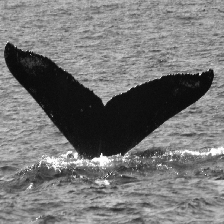

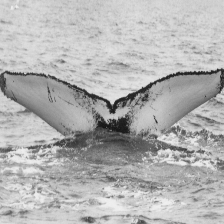

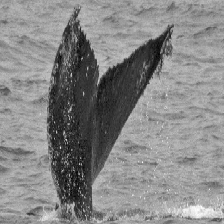

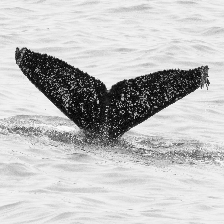

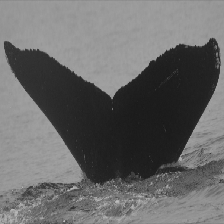

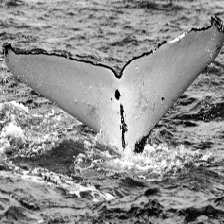

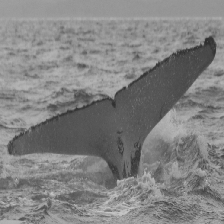

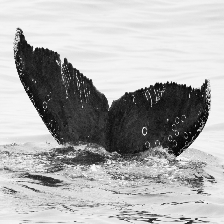

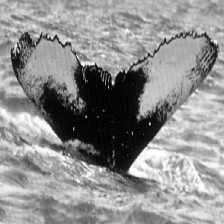

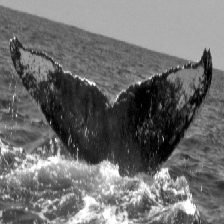

In [25]:
# Visializing some data from training set
from IPython.display import display

for train_filename in train_filenames[:10]:
    img = load_image(os.path.join(DATA_FOLDER, 'train', train_filename))
    display(img)

In [27]:
# Creating training set

def path_to_tensor(path):
    # loads RGB image as PIL.Image.Image type
    img = load_image(path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    image_array = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(image_array, axis=0)

def get_train_set(load_from_file=False, saved_set=os.path.join(DATA_FOLDER, 'train_set.npy')):
    if load_from_file:
        print('loading training set from', saved_set)
        return np.load(saved_set)
    else:
        print('calculating training set')
        return np.vstack([path_to_tensor(train_filename) for train_filename in train_filenames])

train_set = get_train_set(True)
train_set.shape

loading training set from data/train_set.npy


(15697, 224, 224, 1)

In [84]:
train_labels_ordered = np.empty(train_labels.shape, dtype=train_labels.dtype)
for i, train_filename in enumerate(train_filenames):
    train_labels_ordered[i] = train_labels[train_labels['filename'] ==  train_filename]
    
assert train_filenames[:10] == train_labels_ordered['filename'].tolist()[:10]

In [130]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train_labels_ordered['whale_id'])
print(integer_encoded)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

assert onehot_encoded.shape == (len(train_labels_ordered), len(np.unique(train_labels_ordered['whale_id'])))

[ 608  940 2316 ... 3070 4431 4502]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/Users/oleg/.pyenv/versions/3.7.1/envs/humpback/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [131]:
import math

train_set_size = int(math.floor(len(train_set) * 0.8))
valid_set_size = len(train_set) - train_set_size

sub_train_set = train_set[:train_set_size]
sub_train_labels = onehot_encoded[:train_set_size]
valid_set = train_set[train_set_size:]
valid_labels = onehot_encoded[train_set_size:]

assert len(sub_train_set) + len(valid_set) == len(train_set) 
assert len(sub_train_labels) + len(valid_labels) == len(onehot_encoded) 

In [132]:
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

def get_model_fine_to_coarse(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=4, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Conv2D(filters=64, kernel_size=8, padding='valid', activation='relu'))
    model.add(AveragePooling2D(pool_size=8))
    model.add(Conv2D(filters=128, kernel_size=16, padding='same', activation='relu'))
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = get_model_fine_to_coarse((224, 224, 1), num_classes=len(np.unique(train_labels_ordered['whale_id'])))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 223, 223, 16)      80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 108, 108, 32)      8224      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 64)        131136    
_________________________________________________________________
average_pooling2d_4 (Average (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 128)         2097280   
__________

In [133]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.hdf5', 
                               verbose=1, save_best_only=True)
early_stop = EarlyStopping(patience=5, verbose=1)

model.fit(sub_train_set, sub_train_labels, 
          validation_data=(valid_set, valid_labels),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stop], verbose=1)

Train on 12557 samples, validate on 3140 samples
Epoch 1/20
 3040/12557 [======>.......................] - ETA: 3:53 - loss: 16.0429 - acc: 0.0013